In [1]:
using AngularPowerSpectra
using Healpix
using PyCall, PyPlot
using CSV, DataFrames, LinearAlgebra
using BenchmarkTools
using Distributions, Random
import ThreadPools: @qthreads
using BenchmarkTools
hp = pyimport("healpy")
nmt = pyimport("pymaster")

┌ Info: Precompiling AngularPowerSpectra [f5ca4f4d-e898-4791-800e-627d1338a64b]
└ @ Base loading.jl:1260
┌ Warning: Package AngularPowerSpectra does not have Distributions in its dependencies:
│ - If you have AngularPowerSpectra checked out for development and have
│   added Distributions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with AngularPowerSpectra
└ Loading Distributions into AngularPowerSpectra from project dependency, future warnings for AngularPowerSpectra are suppressed.


PyObject <module 'pymaster' from '/home/zequnl/anaconda3/envs/ps/lib/python3.7/site-packages/pymaster-1.0.2-py3.7-linux-x86_64.egg/pymaster/__init__.py'>

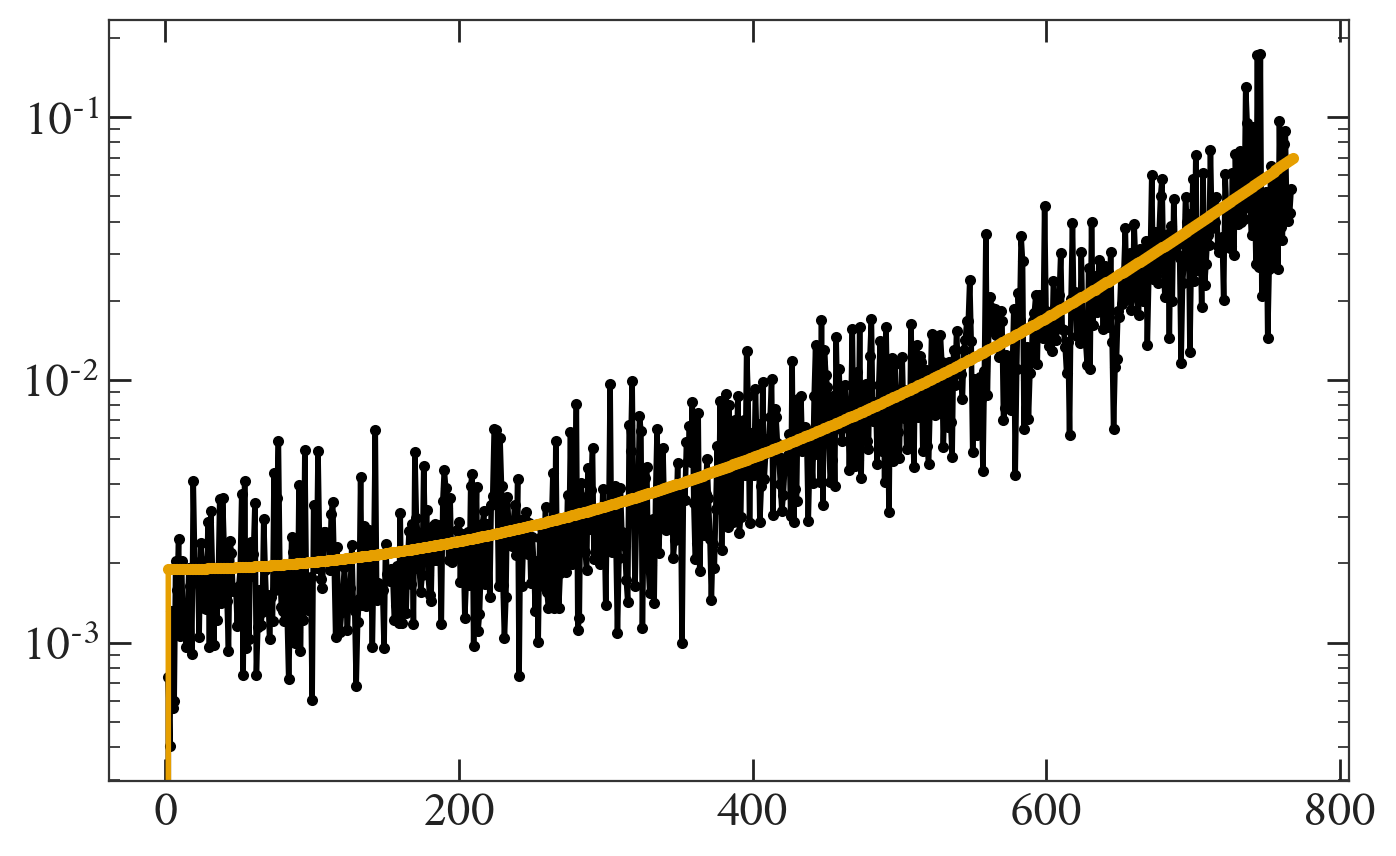

In [5]:
nside = 256
mask1 = Map{Float64, RingOrder}(ones(nside2npix(nside)))
mask2 = Map{Float64, RingOrder}(ones(nside2npix(nside)))

beam1 = SpectralVector(ones(3 * nside))
beam2 = SpectralVector(ones(3 * nside))

theory = CSV.read("data/theory.csv")
noise = CSV.read("data/noise.csv")
nltt = convert(Vector{Float64}, noise.nltt)

nalm0 = generate_correlated_noise(nside, 10 * 2π / 180, nltt)
pow = alm2cl(nalm0)
x = Float64.(collect(eachindex(pow)))
y = log.(pow)

plot(pow)
n0 = 1.5394030890788515 / nside
plot(nltt)
yscale("log")

In [9]:
flat_mask = Map{Float64, RingOrder}(ones(nside2npix(nside)) )
m_143_hm1 = Field("143_hm1", mask1, flat_mask, beam1)
m_143_hm2 = Field("143_hm2", mask2, flat_mask, beam2)
workspace = SpectralWorkspace(m_143_hm1, m_143_hm2, m_143_hm1, m_143_hm2)
@time mcm = compute_mcm(workspace, "143_hm1", "143_hm2")
@time factorized_mcm = cholesky(Hermitian(mcm.parent));

  4.067313 seconds (2.00 M allocations: 101.226 MiB, 1.36% gc time)
  0.035333 seconds (30.20 k allocations: 5.972 MiB)


In [10]:
function get_sim(nside, nltt)
    pixwin = true
    signal = hp.synfast(theory.cltt, 
        nside, verbose=false, pixwin=pixwin, new=true)

    n1 = alm2map(
        generate_correlated_noise(nside, 10 * 2π / 180, nltt),
        nside)
    n2 = alm2map(
        generate_correlated_noise(nside, 10 * 2π / 180, nltt),
        nside)

    map1 = Map{Float64, RingOrder}(nside)
    map1.pixels .= hp.sphtfunc.smoothing(signal .+ n1, beam_window=beam1, verbose=false)
    map2 = Map{Float64, RingOrder}(nside)
    map2.pixels .= hp.sphtfunc.smoothing(signal .+ n2, beam_window=beam2, verbose=false)
    Clhat = compute_spectra(map1 * mask1, map2 * mask2, factorized_mcm, beam1, beam2)
    return Clhat
end

function generate_sim_array(nsims)
    result = Array{Float64, 2}(undef, (3 * nside, nsims))
    for i in 1:nsims
        Clhat = get_sim(nside, nltt)
        result[:,i] .= Clhat
    end
    return result
end

generate_sim_array (generic function with 1 method)

In [ ]:
sims = generate_sim_array(30)